# Imports

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, RocCurveDisplay, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from scipy.stats import randint

# Train/test split

In [6]:
df = pd.read_csv('./df_final.csv')

In [8]:
X = df.drop(columns = 'target_encoded')
y = df['target_encoded']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Scale the Data

In [12]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)

X_test_sc = sc.transform(X_test)

# Random Forest

In [101]:
class_labels = ['no_award', 'team_1st', 'team_2nd', 'team_3rd']

In [105]:
def evaluate_model(model, pred, X_train, y_train, X_test, y_test):
    # Evaluate the model. We care most about the f1 score based on how imbalanced our classes are.
    f1_scores = f1_score(y_test, pred, average = None)
    recall_scores = recall_score(y_test, pred, average = None)
    precision_scores = precision_score(y_test, pred, average = None)
    
    print(f'Training Accuracy: {model.score(X_train, y_train)}')
    print(f'Testing Accuracy: {model.score(X_test, y_test)}')
    
    print(f'F1 Score:')
    for i, f1 in enumerate(f1_scores):
        print(f' {class_labels[i]}: {f1:.4f}')

    print(f'Recall Score:')
    for i, recall in enumerate(recall_scores):
        print(f' {class_labels[i]}: {recall: .4f}')

    print(f'Precision Score:')
    for i, precision in enumerate(precision_scores):
        print(f' {class_labels[i]}: {precision:.4f}')

    cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels= ['no_award', 'team_1st', 'team_2nd', 'team_3rd'])

    cmd.plot();

Training Accuracy: 1.0
Testing Accuracy: 0.9765807962529274
F1 Score:
 no_award: 0.9907
 team_1st: 0.6789
 team_2nd: 0.2857
 team_3rd: 0.0816
Recall Score:
 no_award:  0.9989
 team_1st:  0.6607
 team_2nd:  0.2000
 team_3rd:  0.0455
Precision Score:
 no_award: 0.9827
 team_1st: 0.6981
 team_2nd: 0.5000
 team_3rd: 0.4000


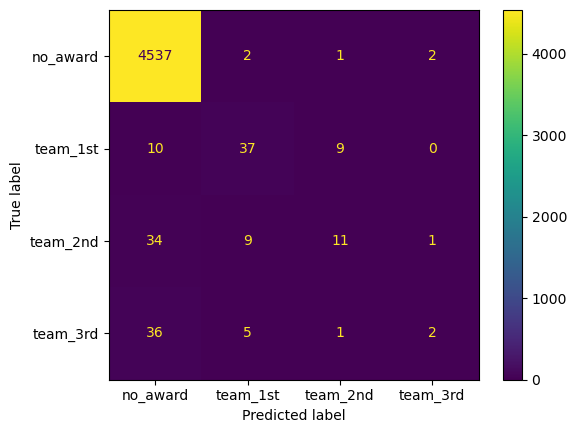

In [106]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sc, y_train)
# Predict on the test data
pred = rf.predict(X_test_sc)

print(f'
evaluate_model(rf, pred, X_train_sc, y_train, X_test_sc, y_test)

It looks like our class imbalance is heavily skewing our model. We do a good job of predicting no award but not such a great job of predicting the other classes. Our model is also heavily struggling with false negatives and false positives for most of the all_nba teams.

# Changing Random Forest Class Weight

Training Accuracy: 1.0
Testing Accuracy: 0.975729188843943
F1 Score:
 no_award: 0.9902
 team_1st: 0.6667
 team_2nd: 0.1892
 team_3rd: 0.0435
Recall Score:
 no_award:  0.9998
 team_1st:  0.6071
 team_2nd:  0.1273
 team_3rd:  0.0227
Precision Score:
 no_award: 0.9808
 team_1st: 0.7391
 team_2nd: 0.3684
 team_3rd: 0.5000


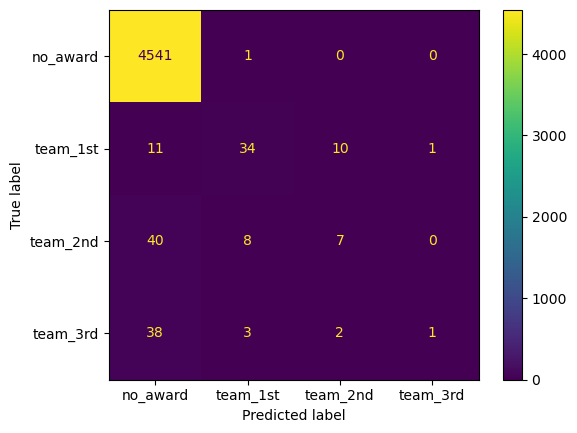

In [107]:
rf = RandomForestClassifier(n_estimators=100, class_weight= 'balanced', random_state=42)
rf.fit(X_train_sc, y_train)

# Predict on the test data
pred = rf.predict(X_test_sc)

evaluate_model(rf, pred, X_train_sc, y_train, X_test_sc, y_test)

Didn't help much. Still misclassifying most classes as no_award.

# Over-Sampling

In [139]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('smo', SMOTE(random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balance'))])

params = {
    'smo__k_neighbors': [3, 5, 10],
    'rf__n_estimators': randint(100, 501),
    'rf__max_depth': [None, 10, 20, 50],
    'rf__min_samples_split': randint(2, 11),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': [None, 'balanced'],
    'rf__criterion': ['gini', 'entropy'],
    'rf__bootstrap': [True, False]
}
    
grid = RandomizedSearchCV(pipe,
                      param_distributions=params,
                    n_iter=100,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                   random_state=42)

grid.fit(X_train, y_train)

/Users/eliwinton/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
148 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/eliwinton/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eliwinton/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eliwinton/anaconda3/lib/python3.11/site-packages/imblearn/pipe

RandomizedSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('smo',
                                              SMOTE(random_state=42,
                                                    sampling_strategy={0: 18169,
                                                                       1: 9000,
                                                                       2: 9000,
                                                                       3: 9000})),
                                             ('rf',
                                              RandomForestClassifier(class_weight='balance',
                                                                     random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__class_weight': [None, 'balanced'],
                                        'rf__criterion': ['gin...
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x304f14a10>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x304f15850>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x304f148d0>,
                                        'smo__k_neighbors': [3, 5, 10]},
                   random_state=42, scoring='f1_weighted')

In [140]:
grid.best_params_
grid.best_score_

{'rf__bootstrap': False,
 'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 225,
 'smo__k_neighbors': 5}

In [ ]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('smo', SMOTE(random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balance'))])

params = {
    'smo__k_neighbors': 5,
    'rf__n_estimators': 225,
    'rf__max_depth': [None],
    'rf__min_samples_split': [1, 2],
    'rf__min_samples_leaf': 1,
    'rf__max_features': ['sqrt'],
    'rf__class_weight': ['balanced'],
    'rf__criterion': ['gini'],
    'rf__bootstrap': [False]
}
    
grid = RandomizedSearchCV(pipe,
                      param_distributions=params,
                    n_iter=100,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                   random_state=42)

grid.fit(X_train, y_train)

In [ ]:
pipe_2 = Pipeline([
    ('ss', StandardScaler()),
    ('ada', ADASYN(random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(random_state=42))])

params = {
    'ada__n_neighbors': randint(3, 11),
    'rf__n_estimators': randint(100, 501),
    'rf__max_depth': [None, 10, 20, 50],
    'rf__min_samples_split': randint(2, 11),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__class_weight': [None, 'balanced'],
    'rf__criterion': ['gini', 'entropy'],
    'rf__bootstrap': [True, False]
}
    
grid_2 = RandomizedSearchCV(pipe_2,
                      param_distributions=params,
                    n_iter=50,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                    cv=3,
                   random_state=42)

grid_2.fit(X_train, y_train)

In [ ]:
grid_2.best_params_
grid_2.best_score_